# Instacart: Forecasting (Part II)

by [Raul Maldonado](https://www.linkedin.com/in/raulm8)


**STILL IN DEVELOPMENT**

![InstaCart Logo](https://bloximages.chicago2.vip.townnews.com/pinalcentral.com/content/tncms/assets/v3/editorial/e/4c/e4cb9197-ddce-59e1-93c7-2868e145c705/5b858c3f5e8de.image.jpg?resize=400%2C212)

## 1. Introduction

**Background**:

Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.


From the Instacart Kaggle data, we will explore some potential modeling opportunities for

* Reorder Predictions
* Type of Product to be re-ordered

Enjoy!

### Import

In [106]:
import os
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

plt.rcParams["axes.grid"] = False

import seaborn as sns

# Personal information via Localfile in
# the Resources/Admin folder.
import sys
sys.path.append("../Resources/Admin")
path = os.path.join('..','Resources','Data','RawData')

In [107]:
aislesDf = pd.read_csv(f'{path}/aisles.csv')
departmentsDf = pd.read_csv(f'{path}/departments.csv')
productsDf = pd.read_csv(f'{path}/products.csv')
ordersDf = pd.read_csv(f'{path}/orders.csv')
order_products_prior = pd.read_csv(f'{path}/order_products__prior.csv')
order_products_train = pd.read_csv(f'{path}/order_products__train.csv')

In [108]:
ordersDf_train = ordersDf[ordersDf['eval_set']=='train']

In [109]:
orderProducts_trainDf = ordersDf_train.merge(order_products_train, 
                        how='inner', on=['order_id','order_id'])

reorder_dataset = orderProducts_trainDf[['reordered',
                        'order_dow','order_hour_of_day']]


## 2. Forecasting

### Re-order Classification

We first want to gauge what attributes can indicate as signals for reordering. In particular, can we predict what type of customer behaviour lead to re-ordering products via Instacart?

In [110]:
X = reorder_dataset[['order_dow','order_hour_of_day']]
y = reorder_dataset['reordered']

In [111]:
X = pd.get_dummies(data= X, columns =['order_dow'])
y = y.values.reshape(-1,1)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,\
                                                    test_size=0.25,random_state=12)

In [114]:
from sklearn.linear_model import LogisticRegression

model_logReg = LogisticRegression()
model_logReg.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import classification_report

In [117]:
predict_logReg = model_logReg.predict(X_test)

In [118]:
model_logReg.score(X_test,y_test)

0.5985931158007252

In [120]:
print(classification_report(y_test, predict_logReg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    138949
           1       0.60      1.00      0.75    207206

   micro avg       0.60      0.60      0.60    346155
   macro avg       0.30      0.50      0.37    346155
weighted avg       0.36      0.60      0.45    346155



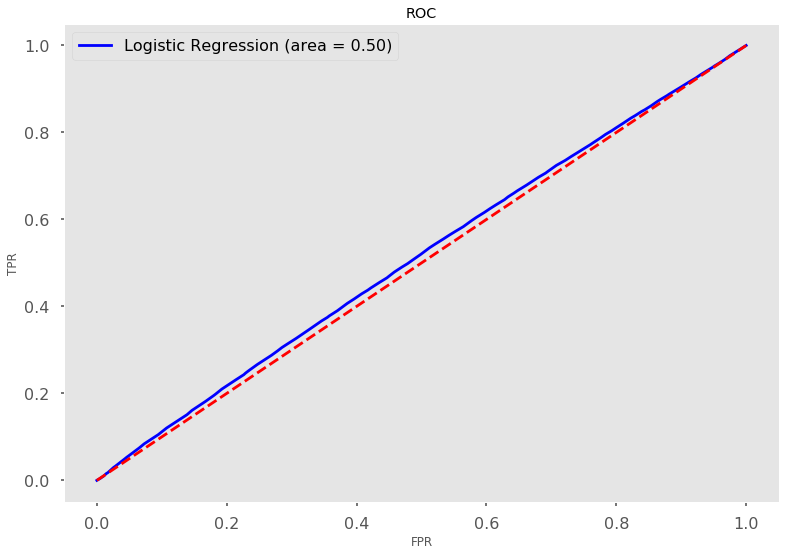

In [128]:
from sklearn.metrics import roc_auc_score, roc_curve
logit_roc_auc = roc_auc_score(y_test,predict_logReg)
fpr, tpr, thresholds = roc_curve(y_test, model_logReg.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, c='b',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

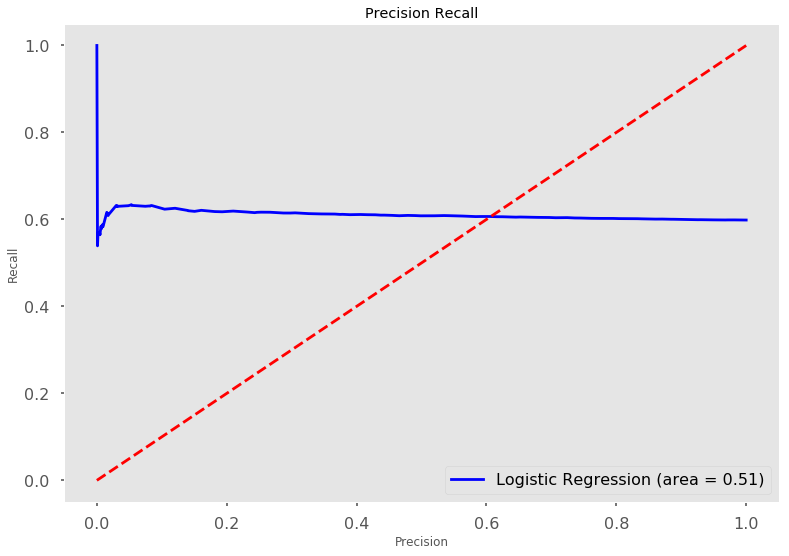

In [134]:
pre, recall, thresholds = precision_recall_curve(y_test, model_logReg.predict_proba(X_test)[:,1])

plt.plot(recall, pre, c='b',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.title('Precision Recall')
plt.show()

**Thoughts:**

We observe that our target data appears to have a measureable impact for predicting re-orders (1) with an f1-score of .75. However, just looking at the f-1score isn't enough due to the observed, major, imbalance of our classification. Therefore, this model is performing poorly.

To deal with this imbalance, we can take one of the following measures to correct for this:

* Re-sampling
* Over or Under Sampling
* Cost Sensitive Learning
* Synthetic Minority Oversampling Technique (SMOTE)
* And more

> [Source](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/)

**The following** is an attempt to improve the overall f1-score performance by balancing the weights of the target class through formulat $\tfrac{\text{n_samples}}{\text{n_classes} * \text{Binary Count(y)}}$:

In [92]:
model_logReg2 = LogisticRegression(class_weight = 'balanced')

In [93]:
model_logReg2.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [94]:
predict_logReg2 = model_logReg2.predict(X_test)

In [96]:
print(classification_report(y_test, predict_logReg2))

              precision    recall  f1-score   support

           0       0.41      0.51      0.46    138949
           1       0.61      0.51      0.55    207206

   micro avg       0.51      0.51      0.51    346155
   macro avg       0.51      0.51      0.50    346155
weighted avg       0.53      0.51      0.51    346155



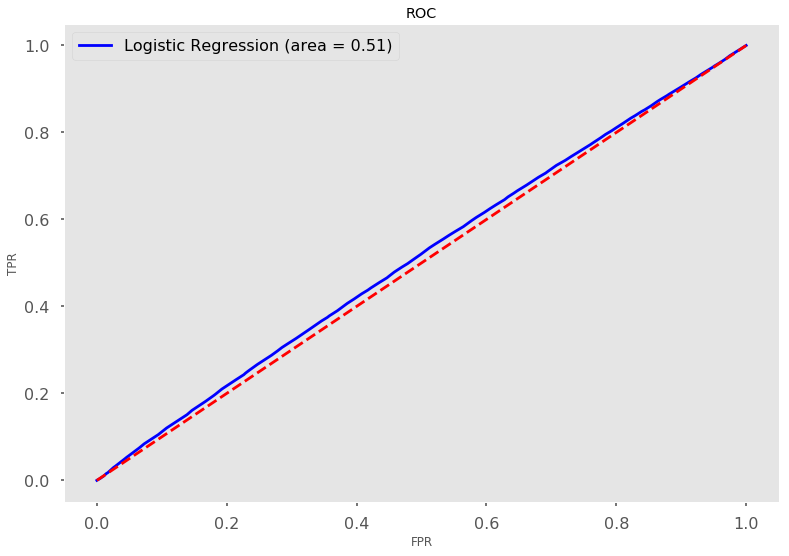

In [130]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

logit_roc_auc = roc_auc_score(y_test, predict_logReg2)

fpr, tpr, thresholds = roc_curve(y_test, model_logReg2.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, c='b',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

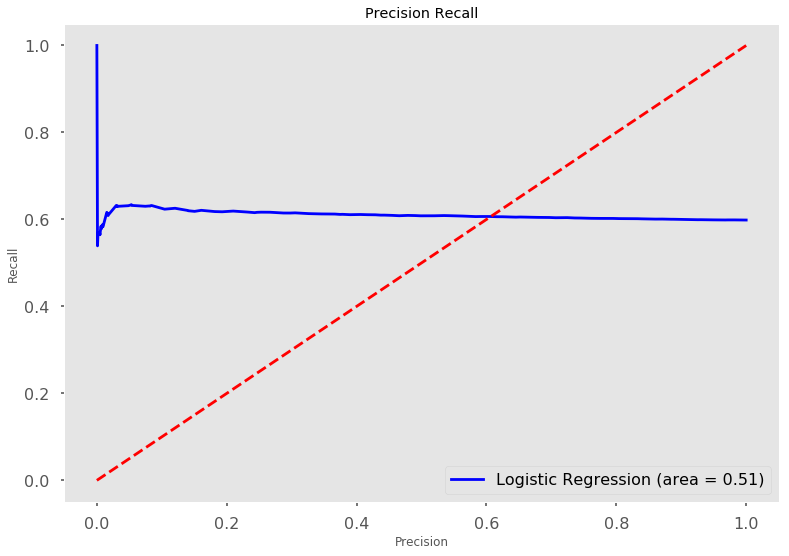

In [133]:
pre, recall, thresholds = precision_recall_curve(y_test, model_logReg2.predict_proba(X_test)[:,1])

plt.plot(recall, pre, c='b',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.title('Precision Recall')
plt.show()

We observe overall increases for non-reordered class (0), with adjustment to the latter class. That is, we see a better representation of classification for the binary re-order scenario when implementing an adjustment from the original bias'd target.

However, we are still in the predicament of our model development not being a great performer for re-order classification. (e.g. our model may tend to randomly get values correct as opposed to performing as a forecasting model, as expected) 

Moreover, we want to identify more features than the existing time-related features to improve our re-order predictions. A great way to go about both measuring model performance of bias target with feature selection is an ensemble method, particularly for this instance Random Forest.

In [135]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

In [136]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [138]:
prediction_rf = model_rf.predict(X_test)

In [139]:
model_rf.score(X_test, y_test)

0.5985786714044287

In [176]:
print(classification_report(y_test,prediction_rf))

              precision    recall  f1-score   support

           0       0.40      0.00      0.00    138949
           1       0.60      1.00      0.75    207206

   micro avg       0.60      0.60      0.60    346155
   macro avg       0.50      0.50      0.37    346155
weighted avg       0.52      0.60      0.45    346155



In [145]:
orderProducts2_trainDf = ordersDf_train.merge(order_products_train, 
                        how='inner', on=['order_id','order_id'])\
            .merge(productsDf, 
                   how='inner',on=['product_id','product_id'])

In [146]:
reordered_df2 = orderProducts2_trainDf[['reordered',
                        'order_dow','order_hour_of_day',
                       'product_id','aisle_id']]

In [151]:
X_2 = reordered_df2.drop('reordered', axis=1)
y_2 = reordered_df2['reordered']

In [158]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, stratify=y_2)

In [159]:
model_rf2 = RandomForestClassifier()
model_rf2.fit(X_train2,y_train2)

In [161]:
model_rf2.score(X_test2,y_test2)

0.5945515737169765

In [162]:
predict_rf2 = model_rf2.predict(X_test2)

In [164]:
print(classification_report(y_test2, predict_rf2))

              precision    recall  f1-score   support

           0       0.49      0.42      0.45    138949
           1       0.65      0.71      0.68    207206

   micro avg       0.59      0.59      0.59    346155
   macro avg       0.57      0.57      0.57    346155
weighted avg       0.59      0.59      0.59    346155



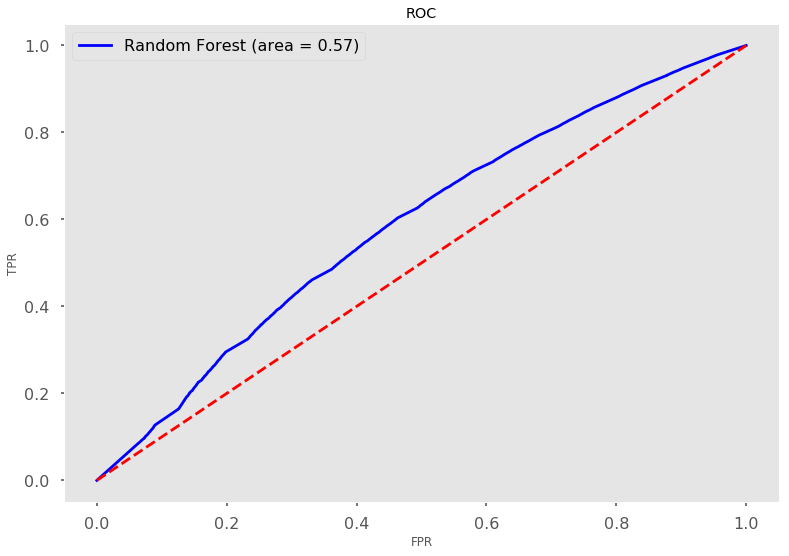

In [174]:
logit_roc_auc = roc_auc_score(y_test2, predict_rf2)

fpr, tpr, thresholds = roc_curve(y_test2, model_rf2.predict_proba(X_test2)[:,1])

plt.plot(fpr, tpr, c='b',label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()

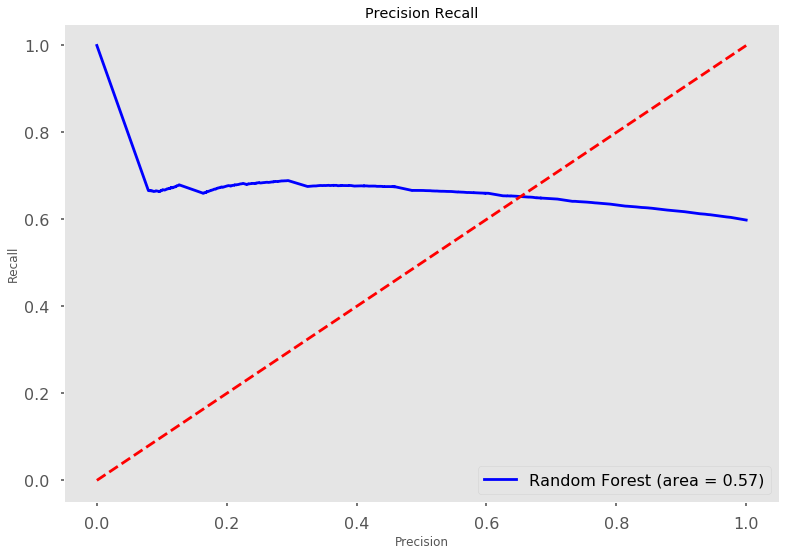

In [175]:
pre, recall, thresholds = precision_recall_curve(y_test2, model_rf2.predict_proba(X_test2)[:,1])

plt.plot(recall, pre, c='b',label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--',c='r')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.title('Precision Recall')
plt.show()

**Summary**:

We observe that for varied classification models like Logistics, Decision Tree, and Random Forest, we were expected to find classification for the imbalanced "re-order" target around 50%-60% accuracy, with individual f1-scores around 50%. Even further, we observe the classifcations were better off randomly guessing than being a performing predictor of re-order for input features like what type of product, time of day, and when the item was purchased. This is indicated in the ROC curve where the curve itself is close to the red linear line of the graph.


**Next Steps.....**

I would like to continue with evaluation of re-order prediction by constructing a model from the following:
1. Obtain more significant features for re-order evaluation

2. Feature Engineering
    
    a. What features to transform to drive more significance in prediction?

3. Class-Imbalance handling

    a. Obtain more samples to handle imbalance of target classes, or handle situation in another way (e.g. SMOTE implementation)
    
To be continued...

### Predicting Next Order Products [TODO]


**Objective:** Predicting product items in the next cart.

Based on the sample data, we find that the information gathered in our prediction is a concatenated list of product ids per order.

Example:

| Order ID       | Products     |
| :------------- | ----------: |
|  123            |          9987 9912 |
| 124  | 9965 99123 12387 |

In [89]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [90]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()


In [91]:
ordersDf_train = ordersDf[ordersDf['eval_set']=='train']


In [92]:
reorder_df = order_products_train.merge(ordersDf_train,left_on='order_id',right_on='order_id',how='left')\
                    .merge(productsDf,on=['product_id','product_id'], how='left')
print("Data's Dimensions: ", reorder_df.shape)

Data's Dimensions:  (1384617, 13)


In [93]:
reorder_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [94]:
reorder_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

In [95]:
#Preliminary Training to main training, by grabbing sample of 2000 data points
reorder_df = reorder_df.sample(n=2000,random_state=42)

features = reorder_df[['order_id','days_since_prior_order','order_hour_of_day',\
                       'aisle_id','department_id','reordered']]
                      
target= reorder_df['product_id']

In [96]:
model.fit(features,target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [97]:
model.score(features,target)

0.9995

In [100]:
reorder_df_prior_demo = order_products_prior.merge(ordersDf_prior,left_on='order_id',right_on='order_id',how='left')\
                    .merge(productsDf,on=['product_id','product_id'], how='left')
print("Data's Dimensions: ", reorder_df_prior_demo.shape)

reorder_df_prior_demo = reorder_df_prior_demo.sample(n=2000,random_state=42)


features_demo = reorder_df_prior_demo[['order_id','days_since_prior_order','order_hour_of_day',\
                       'aisle_id','department_id','reordered']]
                      
target_demo= reorder_df_prior_demo['product_id']

Data's Dimensions:  (32434489, 13)


In [101]:
features_demo[:10]

,order_id,days_since_prior_order,order_hour_of_day,aisle_id,department_id,reordered
29481110,3109255,8.0,19,104,13,0
2852353,301098,1.0,15,83,4,0
11194500,1181866,8.0,17,24,4,0
15909397,1678630,26.0,14,115,7,1
6101870,644090,30.0,19,75,17,0
5278828,557169,10.0,12,129,1,1
6983365,737337,8.0,13,24,4,1
13169449,1389978,16.0,20,45,19,1
4203220,443457,6.0,9,126,11,1
15630910,1649178,17.0,8,120,16,1


In [102]:
prediction_results = model.predict(reorder_df_prior_demo[['order_id','days_since_prior_order','order_dow','order_hour_of_day',\
                       'aisle_id','department_id']][:10])
prediction_results

array([ 9837, 47222, 42585, 41588,  9837, 41362, 41362,  9837, 41362,
        6867])

In [103]:
from sklearn.metrics import classification_report


In [104]:
reorder_df_prior_demo.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
29481110,3109255,34099,16,0,135284,prior,9,0,19,8.0,Crushed Red Chili Pepper,104,13
2852353,301098,41950,5,0,7293,prior,2,4,15,1.0,Organic Tomato Cluster,83,4
11194500,1181866,45066,8,0,111385,prior,2,1,17,8.0,Honeycrisp Apple,24,4
15909397,1678630,8859,2,1,147365,prior,7,0,14,26.0,Natural Spring Water,115,7
6101870,644090,24781,2,0,99290,prior,7,0,19,30.0,"PODS Laundry Detergent, Ocean Mist Designed fo...",75,17


In [115]:
productsDf.loc[productsDf['product_id'].isin(prediction_results)][['product_id','product_name']]

,product_id,product_name
3797,3798,Pink Lady Apples
5604,5605,Sesame Seed
8173,8174,Organic Navel Orange
15289,15290,Orange Bell Pepper
23636,23637,Maple & Brown Sugar High Fiber Instant Oatmeal
33197,33198,Sparkling Natural Mineral Water
33456,33457,Chicken Breast Nuggets
37946,37947,Organic Peach Lowfat Yogurt
39957,39958,Organics Gummy Bears
46021,46022,Baked Whole Grain Wheat Original Crackers Thin...


(TODO): How should I continue? 
1. Feature Selection
2. Feature Engineering (Ratios)
3. Different Model?